# <img style="float: left; padding-right: 20px; width: 100px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"> MDS3050-Actividad de Graduación I
**Pontificia Universidad Católica de Chile**<br>
**Magíster en Ciencia de Datos**<br>
**2024**<br>

----

## Estudio inicial del proyecto

# Introduccion:

El siguiente reporte tiene como finalidad mostrar un avance del estudio inicial realizado con una muestra de los datos a trabajar. Dividimos el dataset en dos grupos: caracterizacion y cursos. El subgrupo de caracterizacion contiene informacion categorica sobre los estudiantes, representada en forma de encuesta. Con este subgrupo se pretende analizar y modelar las relaciones sociales en relacion con el rendimiento academico universitario.

De igual manera, el subgrupo de cursos contiene informacion sobre las evaluaciones, las cuales se dividen en componentes, denotados como `SEQ`. Asimismo se cuenta con el promedio final del curso (`TCKG_GRDE_CODE_FINAL`). El objetivo de trabajo para este subgrupo es explorar la relacion que existe entre los componentes de evaluacion `SEQ` y el rendimiento de los estudiantes, con el proposito de lograr detectar el riesgo de desaprobar en los estudiantes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import load_data
from sklearn.linear_model import LinearRegression

In [2]:
data = load_data()

# Analisis de subgrupo de cursos

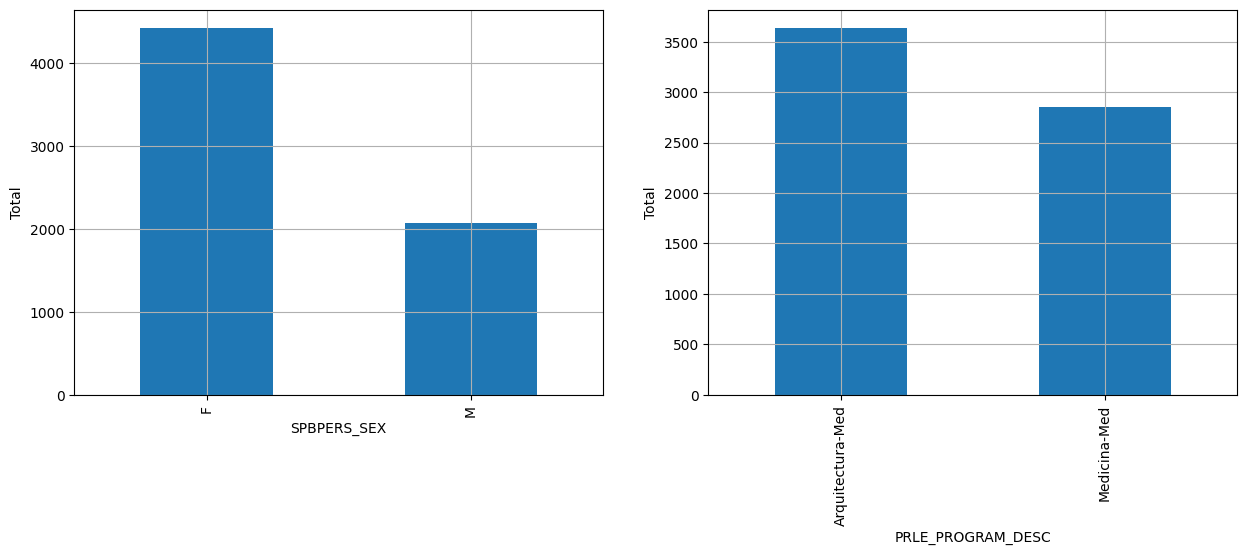

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
data.groupby('SPBPERS_SEX')['CAMPUS'].count().plot(kind = 'bar', ax = ax[0])
data.groupby('PRLE_PROGRAM_DESC')['CAMPUS'].count().plot(kind = 'bar', ax = ax[1])
for k in range(2):
    ax[k].grid();
    ax[k].set_ylabel('Total')

In [4]:
# seleccion en carreras
medicina = data[data['PRLE_PROGRAM_DESC'] == data.PRLE_PROGRAM_DESC.unique()[0]]
arquitectura = data[data['PRLE_PROGRAM_DESC'] == data.PRLE_PROGRAM_DESC.unique()[1]]

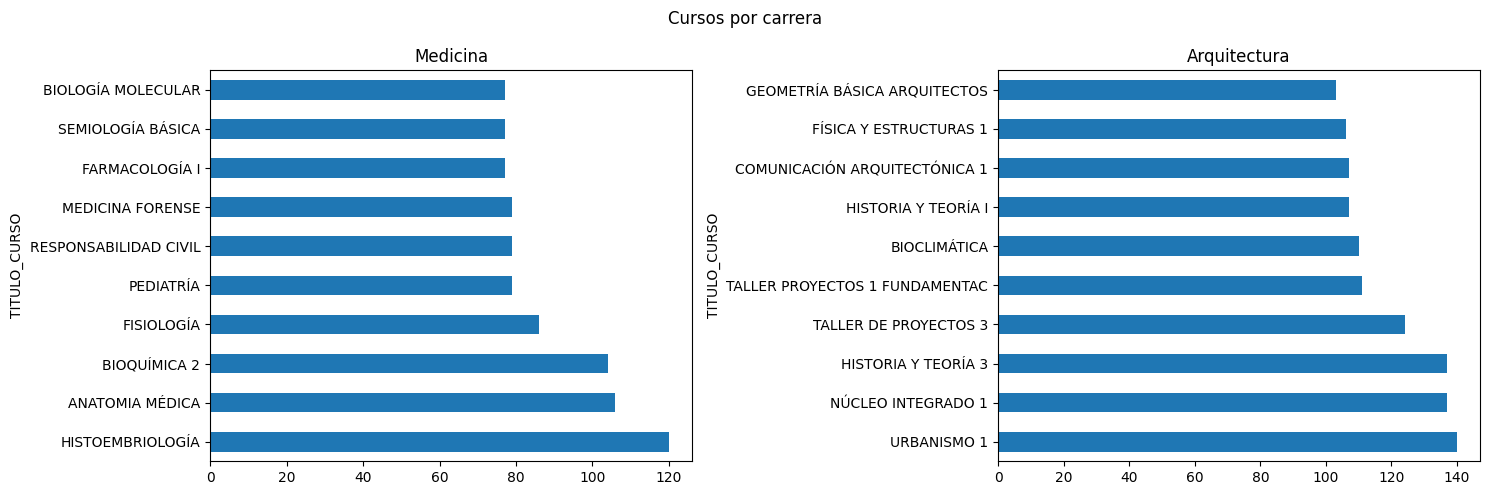

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
medicina.groupby('TITULO_CURSO')['CAMPUS'].count().sort_values(ascending = False).head(10).plot(kind = 'barh', ax = axs[0])
arquitectura.groupby('TITULO_CURSO')['CAMPUS'].count().sort_values(ascending = False).head(10).plot(kind = 'barh', ax = axs[1])
axs[0].set_title('Medicina')
axs[1].set_title('Arquitectura')
fig.suptitle('Cursos por carrera')
fig.tight_layout();

Ahora exploraremos un curso comun para las dos carreras, en este caso corresponde al curso de `LENGUA Y CULTURA`

In [6]:
common_course = 'LENGUA Y CULTURA'

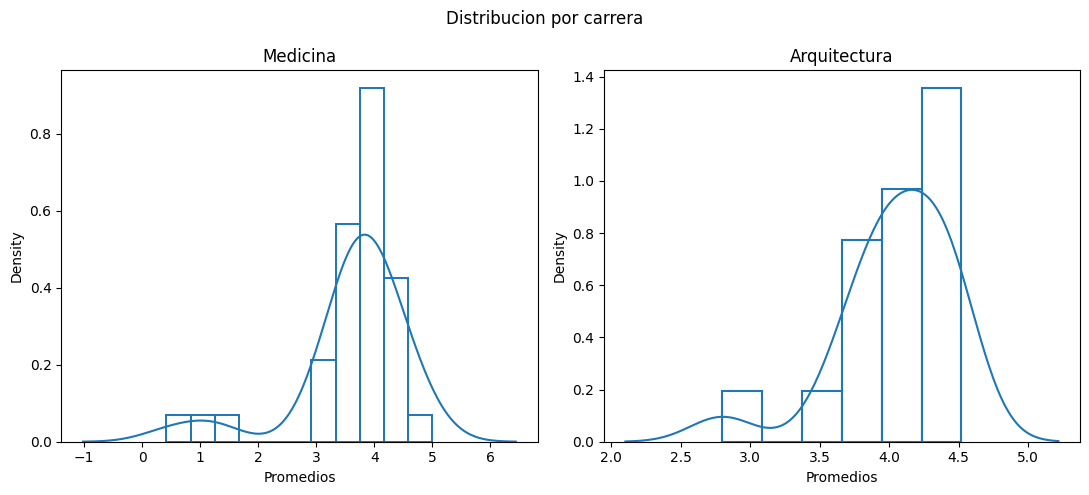

In [7]:
fig, ax = plt.subplots(1, 2 , figsize = (11, 5))
sns.histplot(arquitectura[arquitectura['TITULO_CURSO'] == common_course].iloc[:, 10:].TCKG_GRDE_CODE_FINAL, kde = True, fill = False, stat="density", kde_kws=dict(cut=3), ax = ax[0])#, log_scale = True)
sns.histplot(medicina[medicina['TITULO_CURSO'] == common_course].iloc[:, 10:].TCKG_GRDE_CODE_FINAL, kde = True, fill = False, stat="density", kde_kws=dict(cut=3), ax = ax[1])
fig.tight_layout()
ax[0].set_title('Medicina')
ax[1].set_title('Arquitectura')
ax[0].set_xlabel('Promedios')
ax[1].set_xlabel('Promedios')
fig.suptitle('Distribucion por carrera')
fig.tight_layout();

# Analisis de correlaciones del curso de lengua y literatura

In [8]:
numeric_features = [f'SEQ_{k + 1}' for k in range(20)] + ['TCKG_GRDE_CODE_FINAL']

In [9]:
corr_subset = data[data['TITULO_CURSO'] == common_course].copy()
corr_medicina = corr_subset[corr_subset['PRLE_PROGRAM_DESC'] == corr_subset.PRLE_PROGRAM_DESC.unique()[0]]
corr_arquitectura = corr_subset[corr_subset['PRLE_PROGRAM_DESC'] == corr_subset.PRLE_PROGRAM_DESC.unique()[1]]

## Correlacion general

In [10]:
corr = corr_subset.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.165,0.394,0.255,0.474,0.371,-0.121,0.072,0.125,0.077,0.740
SEQ_2,0.165,1.000,0.397,0.529,0.150,0.035,-0.047,-0.156,-0.093,-0.129,0.482
SEQ_3,0.394,0.397,1.000,0.426,0.117,0.180,-0.158,-0.454,-0.409,-0.482,0.602
SEQ_4,0.255,0.529,0.426,1.000,0.315,0.259,0.116,-0.139,-0.132,-0.166,0.655
SEQ_5,0.474,0.150,0.117,0.315,1.000,0.685,0.178,0.305,0.228,0.276,0.639
SEQ_6,0.371,0.035,0.180,0.259,0.685,1.000,0.119,0.346,0.250,0.283,0.570
SEQ_7,-0.121,-0.047,-0.158,0.116,0.178,0.119,1.000,0.255,0.161,0.166,0.041
SEQ_8,0.072,-0.156,-0.454,-0.139,0.305,0.346,0.255,1.000,0.829,0.872,0.011
SEQ_9,0.125,-0.093,-0.409,-0.132,0.228,0.250,0.161,0.829,1.000,0.804,0.012
SEQ_10,0.077,-0.129,-0.482,-0.166,0.276,0.283,0.166,0.872,0.804,1.000,-0.044


## Correlacion para carrera de medicina

In [11]:
corr_med = corr_medicina.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr_med.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.234,0.464,0.349,0.208,-0.128,-0.448,0.011,0.098,0.001,0.526
SEQ_2,0.234,1.000,0.410,0.294,-0.325,-0.295,-0.542,-0.256,-0.094,-0.265,0.207
SEQ_3,0.464,0.410,1.000,0.196,-0.077,-0.095,-0.511,-0.343,0.017,-0.328,0.493
SEQ_4,0.349,0.294,0.196,1.000,0.672,0.265,-0.545,-0.031,-0.097,-0.205,0.815
SEQ_5,0.208,-0.325,-0.077,0.672,1.000,0.525,-0.074,0.243,0.059,0.175,0.682
SEQ_6,-0.128,-0.295,-0.095,0.265,0.525,1.000,0.079,0.541,0.244,0.351,0.360
SEQ_7,-0.448,-0.542,-0.511,-0.545,-0.074,0.079,1.000,0.526,0.427,0.420,-0.370
SEQ_8,0.011,-0.256,-0.343,-0.031,0.243,0.541,0.526,1.000,0.773,0.790,0.138
SEQ_9,0.098,-0.094,0.017,-0.097,0.059,0.244,0.427,0.773,1.000,0.573,0.254
SEQ_10,0.001,-0.265,-0.328,-0.205,0.175,0.351,0.420,0.790,0.573,1.000,0.007


## Correlacion para carrera de arquitectura

In [12]:
corr_arq = corr_arquitectura.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr_arq.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.082,0.376,0.191,0.498,0.387,-0.018,0.097,0.154,0.130,0.754
SEQ_2,0.082,1.000,0.392,0.547,0.228,0.012,0.227,-0.118,-0.091,-0.042,0.511
SEQ_3,0.376,0.392,1.000,0.465,0.144,0.202,-0.010,-0.508,-0.606,-0.535,0.630
SEQ_4,0.191,0.547,0.465,1.000,0.255,0.208,0.276,-0.183,-0.159,-0.148,0.618
SEQ_5,0.498,0.228,0.144,0.255,1.000,0.701,0.288,0.343,0.310,0.336,0.624
SEQ_6,0.387,0.012,0.202,0.208,0.701,1.000,0.150,0.370,0.306,0.334,0.563
SEQ_7,-0.018,0.227,-0.010,0.276,0.288,0.150,1.000,0.069,-0.045,0.015,0.159
SEQ_8,0.097,-0.118,-0.508,-0.183,0.343,0.370,0.069,1.000,0.867,0.922,-0.017
SEQ_9,0.154,-0.091,-0.606,-0.159,0.310,0.306,-0.045,0.867,1.000,0.948,-0.042
SEQ_10,0.130,-0.042,-0.535,-0.148,0.336,0.334,0.015,0.922,0.948,1.000,-0.029


# Modelamiento basico

En esta seccion, vamos a realizar un modelamiento basico usando una regresion lineal para predecir el promedio de los alumnos de ambas carreras.

In [15]:
linear_reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

In [16]:
linear_reg.fit(corr_subset.iloc[:, 10:-1], corr_subset.TCKG_GRDE_CODE_FINAL)

LinearRegression()

Notar que como ilustracion estamos entrenando con todos los datos del curso de `Lengua y cultura`, idealmente este proceso tendria que llevarse a cabo de una manera msa rigursa usando estragias de validacion cruzada o validacion simple. Sin embargo, para efectos demostrativos estamos interesados en observar si el modelo puede extraer algun patron util de los datos para la prediccion. Adicionalmente, entrenaremos varios modelos, donde para cad uno de ellos iremos agregando un componente `SEQ` de manera iterativa hasta completar `10` componentes:

In [17]:
linear_reg.score(corr_subset.iloc[:, 10:-1], corr_subset.TCKG_GRDE_CODE_FINAL)

0.9083263571418732

## Iteracion de caracteristicas

A continuacion vamos a entrenar varios modelos, en donde vamos a ir agregando caracteristicas

In [33]:
plot_data = pd.DataFrame()
features = []
scores = []
for f in range(10, 21):
    if f == 10:
        pass
    else:
        linear_reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
        linear_reg.fit(corr_subset.iloc[:, 10:f], corr_subset.TCKG_GRDE_CODE_FINAL)
        scores_ = linear_reg.score(corr_subset.iloc[:, 10:f], corr_subset.TCKG_GRDE_CODE_FINAL)
        features.append(f'Feature {f - 10}')
        scores.append(scores_)
plot_data['features'] = features
plot_data['scores'] = scores

En futuras entregas, nos centraremos en desarrollar uno o varios modelos que sean capaces de encotnrar patrones predictivos en todos los cursos del dataset en diferentes carreras.

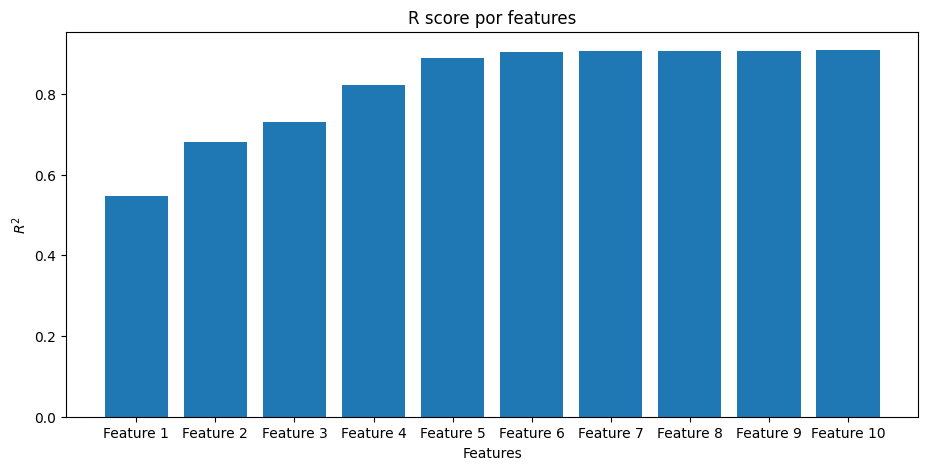

In [35]:
plt.figure(figsize = (11, 5))
plt.bar(x = plot_data['features'], height = plot_data['scores'])
plt.xlabel('Features')
plt.ylabel(r'$R^{2}$')
plt.title('R score por features');